<a href="https://colab.research.google.com/github/Raswanth-Prasath/Negative-Cycle-Canceling-algorithm/blob/main/Negative%20Cycle%20Canceling%20algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Processing fragment 1

Debug info for fragment 1 (before processing):
Number of nodes in graph: 1
Number of edges in graph: 0

Debug info for fragment 1 (after adding to graph):
Number of nodes in graph: 3
Number of edges in graph: 3
Found negative cycle 1: ['v1', 'u1', 's', 'v1']

Final debug info for fragment 1:
Total negative cycles found: 1
Final number of nodes: 3
Final number of edges: 3


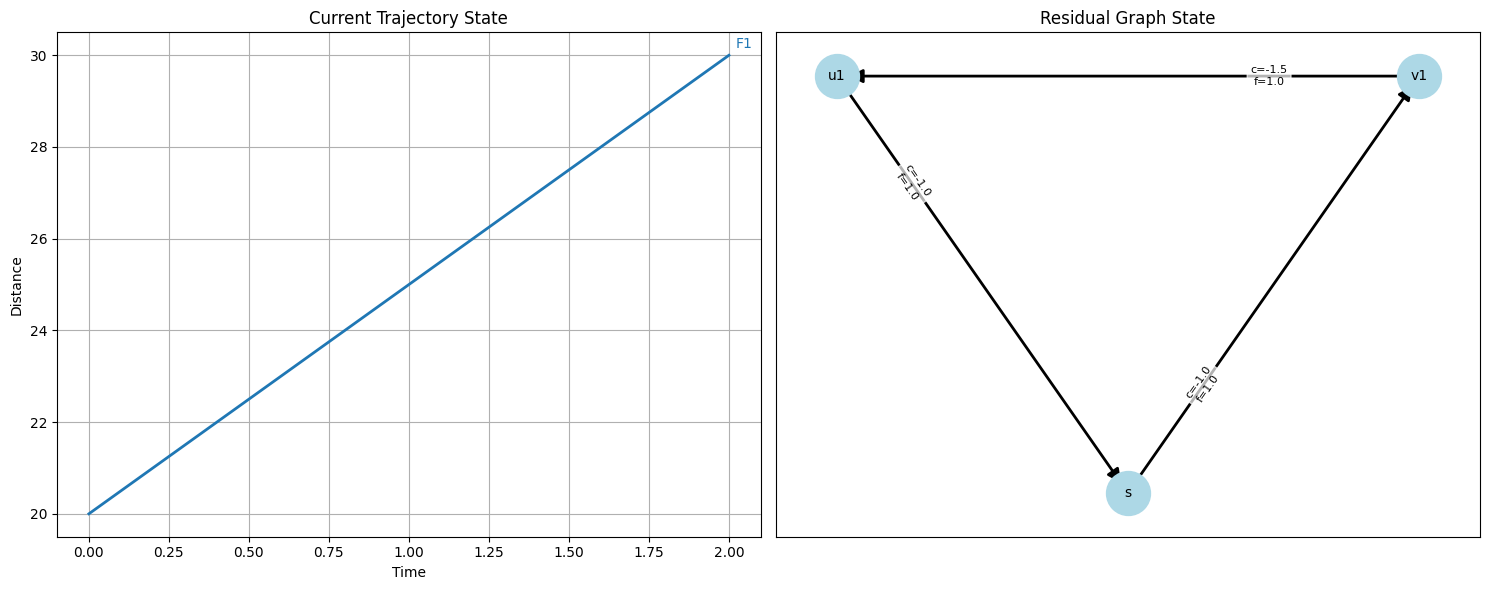

Current trajectories:
Trajectory 1: ['1']

Processing fragment 2

Debug info for fragment 2 (before processing):
Number of nodes in graph: 3
Number of edges in graph: 3
Invalid transition: 1 to 2 - Time overlap
Invalid transition: 2 to 1 - Time overlap

Debug info for fragment 2 (after adding to graph):
Number of nodes in graph: 5
Number of edges in graph: 6
Found negative cycle 1: ['v2', 'u2', 's', 'v2']

Final debug info for fragment 2:
Total negative cycles found: 1
Final number of nodes: 5
Final number of edges: 6


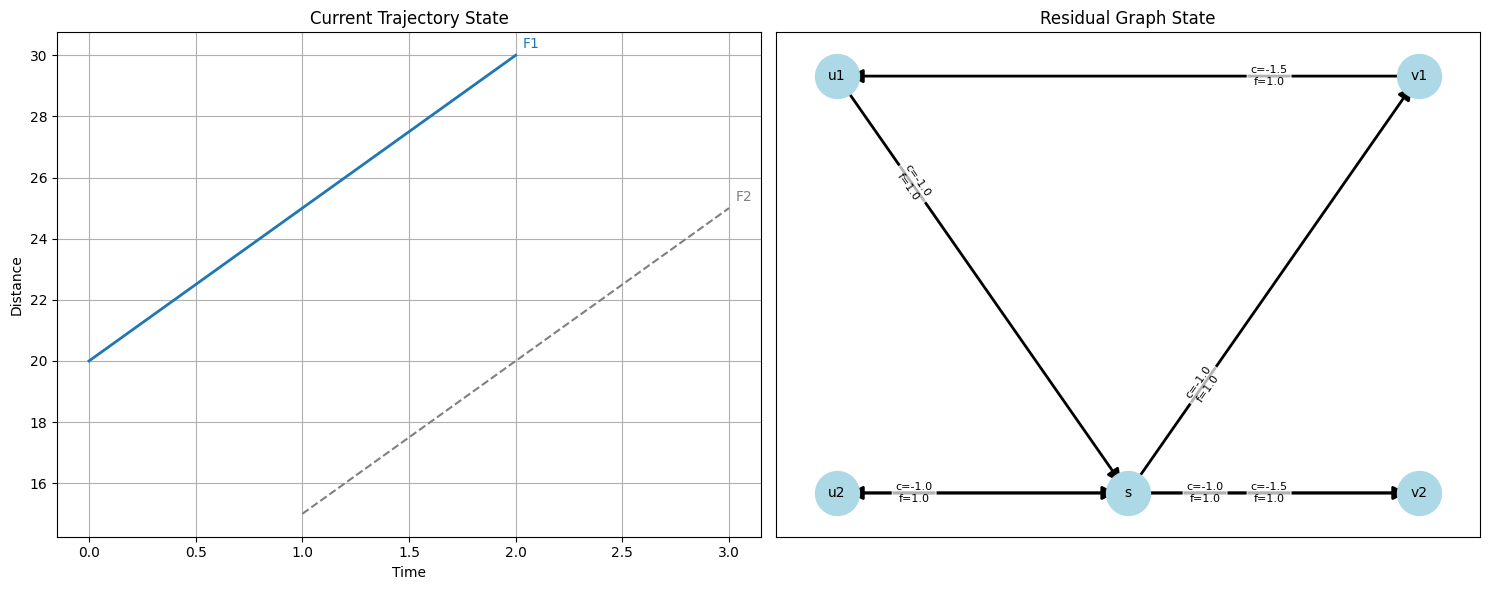

Current trajectories:
Trajectory 1: ['1']

Processing fragment 4

Debug info for fragment 4 (before processing):
Number of nodes in graph: 5
Number of edges in graph: 6
Valid transition: 1 to 4
Transition cost from 1 to 4: 0.5
Added residual edge from u4 to v1
Invalid transition: 4 to 1 - Time overlap
Invalid transition: 2 to 4 - Time overlap
Invalid transition: 4 to 2 - Time overlap

Debug info for fragment 4 (after adding to graph):
Number of nodes in graph: 7
Number of edges in graph: 10
Found negative cycle 1: ['v4', 'u4', 's', 'v4']

Final debug info for fragment 4:
Total negative cycles found: 1
Final number of nodes: 7
Final number of edges: 10


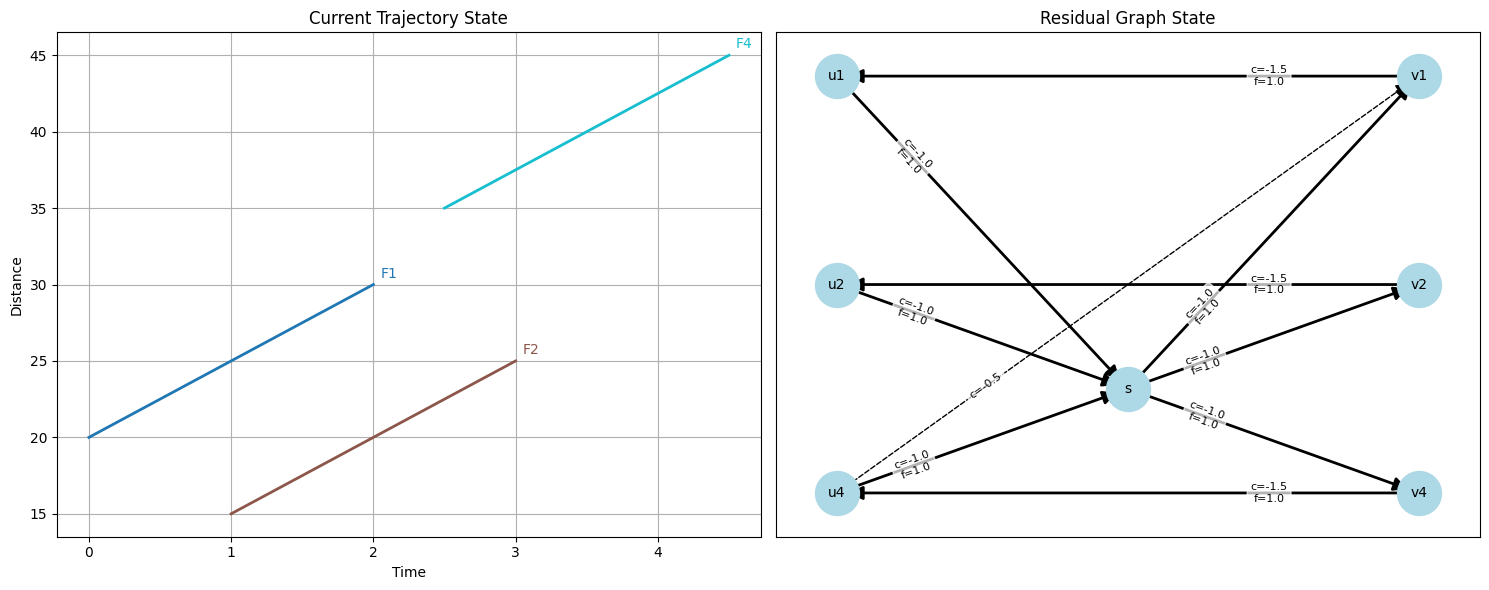

Current trajectories:
Trajectory 1: ['1']
Trajectory 2: ['2']
Trajectory 3: ['4']

Processing fragment 3

Debug info for fragment 3 (before processing):
Number of nodes in graph: 7
Number of edges in graph: 10
Valid transition: 1 to 3
Transition cost from 1 to 3: 2.0
Added residual edge from u3 to v1
Invalid transition: 3 to 1 - Time overlap
Valid transition: 2 to 3
Transition cost from 2 to 3: 0.5
Added residual edge from u3 to v2
Invalid transition: 3 to 2 - Time overlap
Invalid transition: 4 to 3 - Time overlap
Invalid transition: 3 to 4 - Time overlap

Debug info for fragment 3 (after adding to graph):
Number of nodes in graph: 9
Number of edges in graph: 15
Found negative cycle 1: ['v3', 'u3', 's', 'v3']

Final debug info for fragment 3:
Total negative cycles found: 1
Final number of nodes: 9
Final number of edges: 15


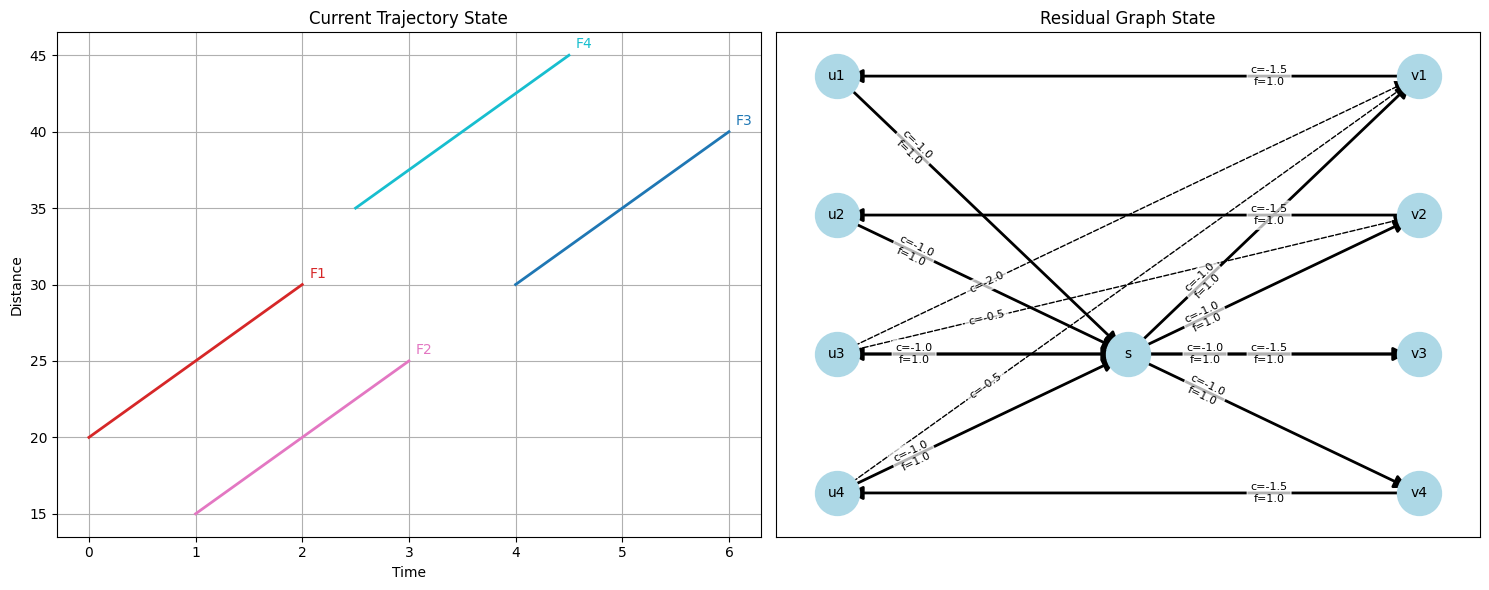

Current trajectories:
Trajectory 1: ['3']
Trajectory 2: ['1']
Trajectory 3: ['2']
Trajectory 4: ['4']


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Optional, Tuple

class ResidualEdge:
    """Represents an edge in the residual graph with flow and cost."""
    def __init__(self, start: str, end: str, cost: float, capacity: float = 1.0):
        self.start = start
        self.end = end
        self.cost = cost
        self.capacity = capacity
        self.flow = 0.0

    @property
    def residual_capacity(self) -> float:
        """Calculates the remaining capacity of the edge."""
        return self.capacity - self.flow

class ResidualGraph:
    """
    Implements the residual graph structure for the Online NCC algorithm.
    """
    def __init__(self):
        self.nodes = {'s'}
        self.edges = {}
        self.fragments = {}

    def _add_edge(self, start: str, end: str, cost: float) -> None:
        """
        Helper method to add an edge to the graph.

        Args:
            start: Starting node name
            end: Ending node name
            cost: Cost of the edge
        """
        self.edges[(start, end)] = ResidualEdge(start, end, cost)

    def add_fragment(self, fragment) -> None:
        """
        Adds a fragment to the graph with negative costs and correct edge directions:
        s → v → u → s pattern for each fragment
        """
        # Store fragment and create nodes
        self.fragments[fragment.id] = fragment
        u_id = f"u{fragment.id}"
        v_id = f"v{fragment.id}"
        self.nodes.add(u_id)
        self.nodes.add(v_id)

        # Add edges for the fragment
        # Source to entry node
        # self._add_edge('s', u_id, compute_entry_cost(fragment))
        # # Entry to exit node (fragment inclusion)
        # self._add_edge(u_id, v_id, compute_inclusion_cost(fragment))
        # # Exit node to source
        # self._add_edge(v_id, 's', compute_exit_cost(fragment))

        # Add structure edges with negative costs
        self._add_edge('s', v_id, -1.0)  # Changed direction: s → v
        self._add_edge(v_id, u_id, -1.5)  # Changed direction: v → u with negative inclusion cost
        self._add_edge(u_id, 's', -1.0)   # Changed direction: u → s

        # Check for valid transitions with existing fragments
        for existing_id, existing_frag in self.fragments.items():
            if existing_id != fragment.id:
                # When we find a valid transition from existing_frag to fragment
                if is_valid_transition(existing_frag, fragment):
                    # Create the residual edge in reverse direction
                    cost = compute_transition_cost(existing_frag, fragment)
                    # Add edge from u_new to v_existing in residual graph
                    self._add_edge(u_id, f"v{existing_id}", cost)
                    print(f"Added residual edge from u{fragment.id} to v{existing_id}")

                # Similarly check transition from fragment to existing_frag
                if is_valid_transition(fragment, existing_frag):
                    cost = compute_transition_cost(fragment, existing_frag)
                    # Add edge from u_existing to v_new in residual graph
                    self._add_edge(f"u{existing_id}", v_id, cost)
                    print(f"Added residual edge from u{existing_id} to v{fragment.id}")

    def find_negative_cycle(self) -> Optional[List[str]]:
        """
        Finds a negative cost cycle in the residual graph using Bellman-Ford.
        Returns None if no negative cycle exists.
        """
        # Create NetworkX DiGraph for cycle detection
        G = nx.DiGraph()
        for edge in self.edges.values():
            if edge.residual_capacity > 0:  # Only add edges with residual capacity
                G.add_edge(edge.start, edge.end, weight=edge.cost)

        # Find negative cycle using Bellman-Ford
        return self._find_negative_cycle_bellman_ford(G)

    def find_negative_cycle(self) -> Optional[List[str]]:
        """
        Finds a negative cost cycle in the residual graph using Bellman-Ford.

        The process:
        1. Create a graph where edges have their costs as weights
        2. Use Bellman-Ford to relax edges and find paths with negative total cost
        3. A negative cycle exists if we can still reduce path costs after |V|-1 relaxations

        Returns:
            List of nodes forming a negative cycle, or None if no negative cycle exists
        """
        # Create NetworkX DiGraph for cycle detection
        G = nx.DiGraph()

        # Add edges with residual capacity AND their costs
        # Only edges with remaining capacity can be part of a negative cycle
        for edge in self.edges.values():
            if edge.residual_capacity > 0:
                G.add_edge(edge.start, edge.end, weight=edge.cost)

        # Now find negative cycle using modified Bellman-Ford
        source = 's'
        nodes = list(G.nodes())
        n = len(nodes)

        # Initialize distances and predecessors
        dist = {node: float('inf') for node in nodes}
        dist[source] = 0
        pred = {node: None for node in nodes}

        # Regular Bellman-Ford relaxation for |V|-1 iterations
        # This finds shortest paths if no negative cycles exist
        for i in range(n-1):
            relaxed = False
            for u, v, data in G.edges(data=True):
                # Important: Use the edge cost/weight for relaxation
                weight = data['weight']  # This is the edge cost
                if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight
                    pred[v] = u
                    relaxed = True

        # After |V|-1 iterations, check for negative cycles
        # If we can still relax edges, a negative cycle exists
        for u, v, data in G.edges(data=True):
            weight = data['weight']
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                # Found a negative cycle! Reconstruct it
                cycle = []
                # Back up until we hit a repeated node
                curr = v
                seen = {curr}
                while True:
                    curr = pred[curr]
                    if curr in seen:
                        # Found cycle - extract it
                        start = curr
                        cycle = [start]
                        curr = pred[start]
                        while curr != start:
                            cycle.append(curr)
                            curr = pred[curr]
                        cycle.append(start)
                        return cycle[::-1]
                    seen.add(curr)

        return None  # No negative cycle found

    def push_flow(self, cycle: List[str]) -> None:
        """
        Pushes one unit of flow through the given cycle.
        """
        # Update flows along the cycle
        for i in range(len(cycle)-1):
            start, end = cycle[i], cycle[i+1]
            if (start, end) in self.edges:
                self.edges[(start, end)].flow += 1
            elif (end, start) in self.edges:
                self.edges[(end, start)].flow -= 1

    def visualize(self, ax=None) -> None:
        """
        Visualizes the residual graph with:
        - Bold lines for min-cost circulation
        - Dashed lines for potential flows
        - Negative costs on all edges
        - Proper s → v → u → s direction
        """
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 6))

        G = nx.DiGraph()

        # Add all nodes
        for node in self.nodes:
            G.add_node(node)

        # Create layout with u and v nodes in columns
        pos = {}
        pos['s'] = np.array([0.5, 0.5])  # Center

        # Position u nodes on left, v nodes on right
        u_nodes = sorted([n for n in self.nodes if n.startswith('u')])
        v_nodes = sorted([n for n in self.nodes if n.startswith('v')])

        spacing = 0.8 / max(len(u_nodes), len(v_nodes))
        for i, node in enumerate(u_nodes):
            pos[node] = np.array([0.2, 0.9 - i * spacing])
        for i, node in enumerate(v_nodes):
            pos[node] = np.array([0.8, 0.9 - i * spacing])

        # Categorize edges
        circulation_edges = []  # Edges with positive flow (bold)
        potential_edges = []    # Edges with zero flow (dashed)

        for edge in self.edges.values():
            if edge.flow > 0:
                circulation_edges.append((edge.start, edge.end))
            else:
                potential_edges.append((edge.start, edge.end))

        # Draw potential edges (dashed black)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=potential_edges,
            edge_color='black',
            style='dashed',
            width=1,
            arrowsize=20
        )

        # Draw circulation edges (bold black)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=circulation_edges,
            edge_color='black',
            style='solid',
            width=2,
            arrowsize=20
        )

        # Draw nodes
        nx.draw_networkx_nodes(
            G, pos,
            node_color='lightblue',
            node_size=1000
        )
        nx.draw_networkx_labels(G, pos, font_size=10)

        # Add edge labels showing costs and flows
        edge_labels = {}
        for e in self.edges.values():
            # Show both cost and flow for circulation edges
            if e.flow > 0:
                label = f"c={e.cost:.1f}\nf={e.flow:.1f}"
            # Show only cost for potential edges
            else:
                label = f"c={-e.cost:.1f}"
            edge_labels[(e.start, e.end)] = label

        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_size=8,
            label_pos=0.25,  # Position label at the center of the edge
            rotate=True,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", alpha=0.7)  # Background box for better visibility
        )

        ax.set_title("Residual Graph State")
        ax.axis('on')
        ax.set_xticks([])
        ax.set_yticks([])

# Helper functions - these would need to be implemented based on your cost model
def compute_transition_cost(fragment1, fragment2) -> float:
    """
    Computes the cost of transitioning from fragment1 to fragment2.
    Uses a more sophisticated cost model that considers:
    1. Temporal proximity
    2. Spatial proximity
    3. Velocity consistency

    Lower cost indicates better match between fragments.
    """
    # Time difference between end of fragment1 and start of fragment2
    dt = fragment2.start_time - fragment1.end_time

    # Get end position of fragment1 and start position of fragment2
    p1 = fragment1.positions[-1]
    p2 = fragment2.positions[0]

    # Compute velocities
    v1 = fragment1.compute_velocity()
    v2 = fragment2.compute_velocity()

    # Predicted position using constant velocity model
    pred_pos = p1 + v1 * dt

    # Various cost components
    time_cost = 0.5 * dt  # Cost increases with time gap

    # Space cost: difference between predicted and actual position
    space_cost = 0.1 * np.linalg.norm(pred_pos - p2)

    # Velocity consistency cost
    vel_diff = np.linalg.norm(v1 - v2)
    vel_cost = 0.2 * vel_diff

    # Total cost with normalization
    total_cost = time_cost + space_cost + vel_cost

    print(f"Transition cost from {fragment1.id} to {fragment2.id}: {total_cost}")

    return total_cost

def is_valid_transition(fragment1, fragment2) -> bool:
    """
    Checks if transition between fragments is valid based on
    physical and temporal constraints.
    """
    # Temporal ordering constraint
    if fragment2.start_time <= fragment1.end_time:
        print(f"Invalid transition: {fragment1.id} to {fragment2.id} - Time overlap")
        return False

    # Time gap constraint
    dt = fragment2.start_time - fragment1.end_time
    if dt > 5.0:  # Maximum 5 second gap
        print(f"Invalid transition: {fragment1.id} to {fragment2.id} - Time gap too large")
        return False

    # Position difference
    dp = fragment2.positions[0] - fragment1.positions[-1]
    dist = np.linalg.norm(dp)

    # Maximum allowed distance based on reasonable velocity
    max_velocity = 30.0  # units per second
    max_dist = max_velocity * dt

    if dist > max_dist:
        print(f"Invalid transition: {fragment1.id} to {fragment2.id} - Distance too large")
        return False

    # Velocity consistency check
    v1 = fragment1.compute_velocity()
    v2 = fragment2.compute_velocity()
    vel_diff = np.linalg.norm(v1 - v2)

    if vel_diff > max_velocity:
        print(f"Invalid transition: {fragment1.id} to {fragment2.id} - Velocity difference too large")
        return False

    print(f"Valid transition: {fragment1.id} to {fragment2.id}")  # ADD THIS
    return True



def compute_entry_cost(fragment) -> float:
    """
    Cost for starting a new trajectory.
    Higher cost discourages creating new trajectories unnecessarily.
    """
    return 2.0

def compute_exit_cost(fragment) -> float:
    """
    Cost for ending a trajectory.
    Higher cost discourages ending trajectories unnecessarily.
    """
    return 2.0

def compute_inclusion_cost(fragment) -> float:
    """
    Cost for including a fragment in a trajectory.
    Negative cost encourages including fragments.
    """
    return -5.0  # Strong incentive to include fragments

class Fragment:
    """
    Represents a trajectory fragment with position measurements over time.
    """
    def __init__(self, id: str, positions: np.ndarray, timestamps: np.ndarray):
        """
        Args:
            id: Unique identifier for the fragment
            positions: Nx2 array of (x,y) positions
            timestamps: N array of corresponding timestamps
        """
        self.id = id
        self.positions = positions
        self.timestamps = timestamps

    @property
    def start_time(self) -> float:
        """Returns the timestamp of the first measurement."""
        return self.timestamps[0]

    @property
    def end_time(self) -> float:
        """Returns the timestamp of the last measurement."""
        return self.timestamps[-1]

    def compute_velocity(self) -> np.ndarray:
        """
        Computes average velocity over the fragment.
        Returns:
            2D velocity vector [vx, vy]
        """
        dt = self.end_time - self.start_time
        if dt == 0:
            return np.zeros(2)
        return (self.positions[-1] - self.positions[0]) / dt

class OnlineTracker:
    """
    Implements the Online Negative Cycle Canceling algorithm for multi-object tracking.
    This class coordinates the entire tracking process, from receiving new fragments
    to outputting complete trajectories.
    """
    def __init__(self):
        # Initialize empty residual graph with just source node
        self.graph = ResidualGraph()
        # Keep track of processed fragments for trajectory extraction
        self.fragments = {}  # Dictionary mapping fragment ID to Fragment object

    def process_fragment(self, fragment: Fragment) -> None:
        """
        Processes a new fragment according to Algorithm 2.
        This is the core function implementing the online NCC algorithm.

        Args:
            fragment: New Fragment object to process
        """
        # First, let's add debug info before we do anything with the fragment
        print(f"\nDebug info for fragment {fragment.id} (before processing):")
        print(f"Number of nodes in graph: {len(self.graph.nodes)}")
        print(f"Number of edges in graph: {len(self.graph.edges)}")

        # Store fragment for later reference
        self.fragments[fragment.id] = fragment

        # Step 1: Add new fragment to residual graph (G-r,k)
        self.graph.add_fragment(fragment)

        # Add debug info after adding the fragment to see how the graph changed
        print(f"\nDebug info for fragment {fragment.id} (after adding to graph):")
        print(f"Number of nodes in graph: {len(self.graph.nodes)}")
        print(f"Number of edges in graph: {len(self.graph.edges)}")

        # Step 2: Find and cancel all negative cycles
        cycle_count = 0
        while True:
            # Find minimum cost negative cycle
            cycle = self.graph.find_negative_cycle()

            # If no negative cycle exists, we're done with this fragment
            if cycle is None:
                break

            # Push flow through the cycle to update graph (G+r,k)
            self.graph.push_flow(cycle)
            cycle_count += 1

            # Add debug info about each cycle found
            print(f"Found negative cycle {cycle_count}: {cycle}")

        # Final debug info after all processing is complete
        print(f"\nFinal debug info for fragment {fragment.id}:")
        print(f"Total negative cycles found: {cycle_count}")
        print(f"Final number of nodes: {len(self.graph.nodes)}")
        print(f"Final number of edges: {len(self.graph.edges)}")

    def extract_trajectories(self) -> List[List[Fragment]]:
        """
        Extracts complete trajectories from the current graph state.
        This implements the FlowToTrajectories function from Algorithm 2.

        Returns:
            List of trajectories, where each trajectory is a list of
            fragments in temporal order
        """
        trajectories = []
        # Start from source node and follow positive flows
        visited_fragments = set()

        # Find all cycles in the graph that carry flow
        G = nx.DiGraph()
        for edge in self.graph.edges.values():
            if edge.flow > 0:
                G.add_edge(edge.start, edge.end)

        # Each cycle starting from 's' represents a trajectory
        for cycle in nx.simple_cycles(G):
            if 's' not in cycle:
                continue

            # Extract fragment IDs from the cycle
            trajectory = []
            for i in range(len(cycle)-1):
                node = cycle[i]
                if node.startswith('u'):  # Entry node of a fragment
                    frag_id = node[1:]  # Remove 'u' prefix
                    if frag_id not in visited_fragments:
                        trajectory.append(self.fragments[frag_id])
                        visited_fragments.add(frag_id)

            if trajectory:
                # Sort fragments by time and add to results
                trajectory.sort(key=lambda f: f.start_time)
                trajectories.append(trajectory)

        return trajectories

    def visualize_current_state(self) -> None:
        """
        Visualizes current state of tracking with:
        1. Space-time plot showing all fragments with proper timestamps and positions
        2. Current state of residual graph
        """
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Space-time visualization
        trajectories = self.extract_trajectories()
        colors = plt.cm.tab10(np.linspace(0, 1, max(len(trajectories), 1)))

        # First plot unassigned fragments in gray
        assigned_fragments = set()
        for traj in trajectories:
            for fragment in traj:
                assigned_fragments.add(fragment.id)

        for frag_id, fragment in self.fragments.items():
            if frag_id not in assigned_fragments:
                # Plot fragment trajectory
                ax1.plot(fragment.timestamps, fragment.positions[:, 0],
                        color='gray', linestyle='--', linewidth=1.5)
                # Add fragment ID label at midpoint
                mid_idx = len(fragment.timestamps) // 2
                ax1.annotate(f'F{frag_id}',
                            (fragment.timestamps[mid_idx],
                            fragment.positions[mid_idx, 0]),
                            xytext=(5, 5), textcoords='offset points',
                            color='gray')

        # Then plot associated fragments in colors
        for traj_idx, (traj, color) in enumerate(zip(trajectories, colors)):
            for fragment in traj:
                # Plot fragment trajectory
                ax1.plot(fragment.timestamps, fragment.positions[:, 0],
                        color=color, linewidth=2)
                # Add fragment ID label at midpoint
                mid_idx = len(fragment.timestamps) // 2
                ax1.annotate(f'F{fragment.id}',
                            (fragment.timestamps[mid_idx],
                            fragment.positions[mid_idx, 0]),
                            xytext=(5, 5), textcoords='offset points',
                            color=color)

        ax1.set_xlabel('Time')
        ax1.set_ylabel('Distance')
        ax1.set_title('Current Trajectory State')
        ax1.grid(True)

        # Set axis limits with some padding
        if self.fragments:
            all_times = np.concatenate([f.timestamps for f in self.fragments.values()])
            all_positions = np.concatenate([f.positions[:, 0] for f in self.fragments.values()])

            time_padding = (all_times.max() - all_times.min()) * 0.05
            pos_padding = (all_positions.max() - all_positions.min()) * 0.05

            ax1.set_xlim(all_times.min() - time_padding,
                        all_times.max() + time_padding)
            ax1.set_ylim(all_positions.min() - pos_padding,
                        all_positions.max() + pos_padding)

        # Plot 2: Residual graph visualization
        self.graph.visualize(ax=ax2)

        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create tracker
    tracker = OnlineTracker()

    # Create sample fragments representing the scenario from the paper's Figure 1
    fragments = [
        Fragment("1",
                positions=np.array([[20, 0], [30, 0]]),
                timestamps=np.array([0, 2])),
        Fragment("2",
                positions=np.array([[15, 0], [25, 0]]),
                timestamps=np.array([1, 3])),
        Fragment("3",
                positions=np.array([[30, 0], [40, 0]]),
                timestamps=np.array([4, 6])),
        Fragment("4",
                positions=np.array([[35, 0], [45, 0]]),
                timestamps=np.array([2.5, 4.5])),
        # Fragment("5",
        #         positions=np.array([[45, 0], [50, 0]]),
        #         timestamps=np.array([7, 9]))
    ]

    # Process fragments in order of last timestamp
    fragments.sort(key=lambda f: f.end_time)

    # Process each fragment and visualize state
    for i, fragment in enumerate(fragments):
        print(f"\nProcessing fragment {fragment.id}")
        tracker.process_fragment(fragment)
        tracker.visualize_current_state()

        # Show current trajectories
        trajectories = tracker.extract_trajectories()
        print("Current trajectories:")
        for j, traj in enumerate(trajectories):
            print(f"Trajectory {j+1}: {[f.id for f in traj]}")
